In [1]:
import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from plotting_utils.distribution_plot import *
from plotting_utils.plotting_metrics import *
from utils.stratification import *
from utils.data_loader import *
from collections import Counter as C

Be careful with running the below code. After running once, set TRICK=False. If ran twice, restart the kernel!

In [2]:
# Trick working directory. Careful not to run cell twice!
TRICK = True
if TRICK:
    %cd ..

/mnt/mnemo1/sum02dean/dean_mnt/projects/MLG/task_1


In [3]:
# Get data
all_genes = load_train_genes()
train_chr = get_train_chr()
df = filter_genes_by_chr(all_genes, train_chr)
df

,gene_name,chr,gene_start,gene_end,TSS_start,TSS_end,strand,gex,cell_line
0,SLC20A1,2,112645939,112663825,112658362,112658412,+,0.000000,1
1,C11orf58,11,16613132,16758340,16738643,16738693,+,2239.103328,1
2,ZSCAN9,6,28224886,28233487,28225263,28225313,+,19.798064,1
3,CD19,16,28931965,28939342,28931956,28932006,+,411.530623,1
4,TMEM123,11,102396332,102470384,102452789,102452839,-,34.214129,1
...,...,...,...,...,...,...,...,...,...
1969,TMPRSS9,19,2360238,2426239,2389785,2389835,+,0.000000,2
1970,PSMA3,14,58244843,58272012,58247788,58247832,+,0.096071,2
1971,PLEKHA4,19,48837097,48868617,48865507,48865557,-,0.000000,2
1972,DENND1C,19,6467207,6482557,6481737,6481787,-,0.000000,2


## Import the data

In [4]:
# Read in the data globally
data_root = 'data/CAGE-train'
files_train = glob.glob(os.path.join(data_root, '*train_y.tsv'))
files_val = glob.glob(os.path.join(data_root, '*val_y.tsv'))

# Global train-test
df_train = pd.concat([pd.read_csv(x, sep='\t') for x in files_train])
df_val= pd.concat([pd.read_csv(x, sep='\t') for x in files_val])

# Cell-line X1
x1_train = pd.read_csv('data/CAGE-train/X1_train_y.tsv', sep='\t')
x1_val = pd.read_csv('data/CAGE-train/X1_val_y.tsv', sep='\t')

# Cell-line X2
x2_train = pd.read_csv('data/CAGE-train/X2_train_y.tsv', sep='\t')
x2_val = pd.read_csv('data/CAGE-train/X2_val_y.tsv', sep='\t')


## Global Level Splits

Here I am showing that there is no signnificant shift in the distribuitions between global train and test test. <br/>
Here global is defined as the training and test seperation across cell-lines and chromosomes.

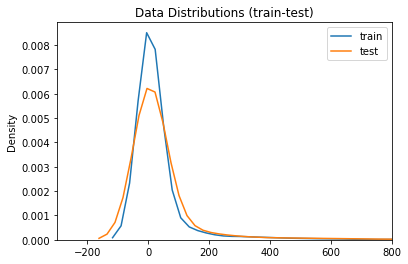

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Data Distributions (train-test)'}, ylabel='Density'>)

In [5]:
plot_kde(df_train.gex, df_val.gex, names=['train', 'test'])

## Investigate Distributions *Within* a Cell-line

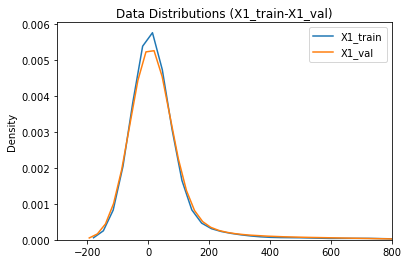

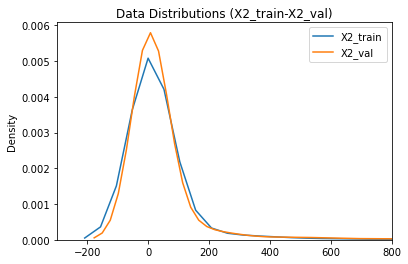

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Data Distributions (X2_train-X2_val)'}, ylabel='Density'>)

In [6]:
# Plot within cell-lines
plot_kde(x1_train.gex, x1_val.gex, names=['X1_train', 'X1_val'])
plot_kde(x2_train.gex, x2_val.gex, names=['X2_train', 'X2_val'])


## Investigate Distributions *Across* Cell-line

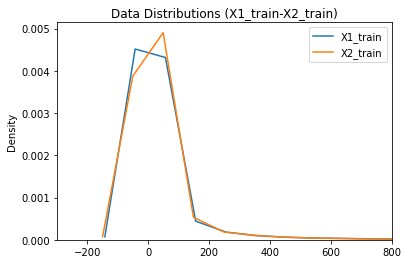

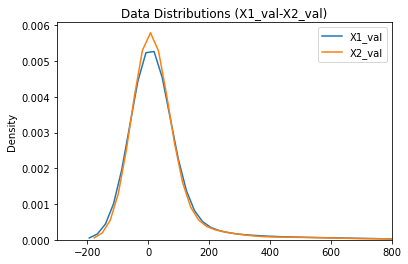

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Data Distributions (X1_val-X2_val)'}, ylabel='Density'>)

In [7]:
# Plot difference between cell-lines
plot_kde(x1_train.gex, x2_train.gex, names=['X1_train', 'X2_train'])


# Plot difference with staggered cell-line split
plot_kde(x1_val.gex, x2_val.gex, names=['X1_val', 'X2_val'])



## Investigate Distributions with *staggered* Cell-line

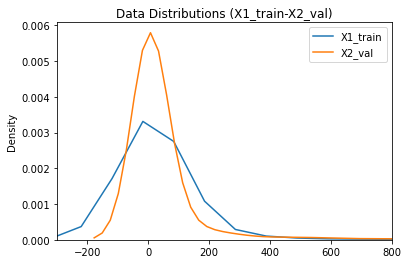

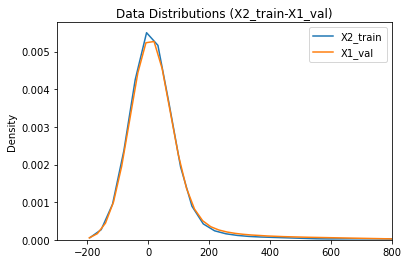

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Data Distributions (X2_train-X1_val)'}, ylabel='Density'>)

In [8]:
plot_kde(x1_train.gex, x2_val.gex, names=['X1_train', 'X2_val'])
plot_kde(x2_train.gex, x1_val.gex, names=['X2_train', 'X1_val'])


## Conclusion

While there doesn't seem to be a covariate shift occuring. We should still test the models on different types of data splits (see below)

# Data Exploration

## Explore Top Highly Variable Genes for a Given Chr

I began to make EDA plots but realised how little time we have till deadline. So I focused on generating different stratifications instead. <br/> This plot shows the top most variable genes between cell-lines X1 and X2 for a given chromosome. The plots rank the metrics by the most variable. The greater the euclidean distance the most disimilar.

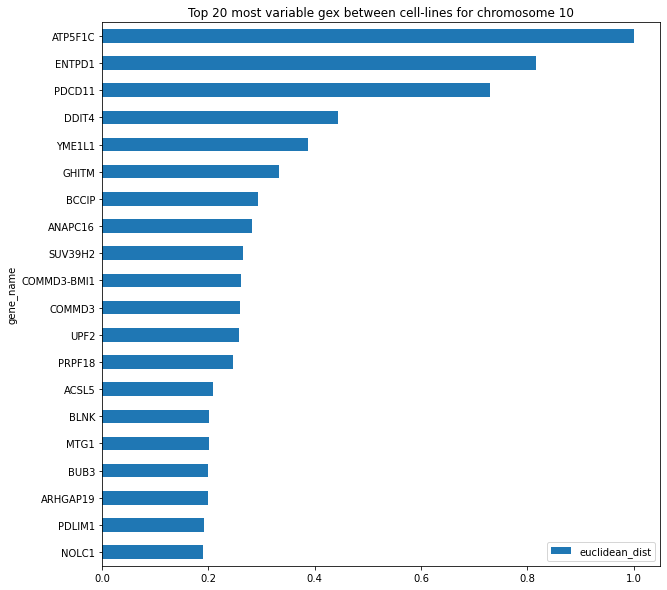

In [9]:
hvg = plot_hvg(chromosome=10, n=20, figsize=(10,10))

### Explore Similarity for Given Chr Between Cell-lines

This plot shows the top most variable chromosomes between cell-lines X1 and X2 (A and B respectively). The greater the euclidean distance the most disimilar.

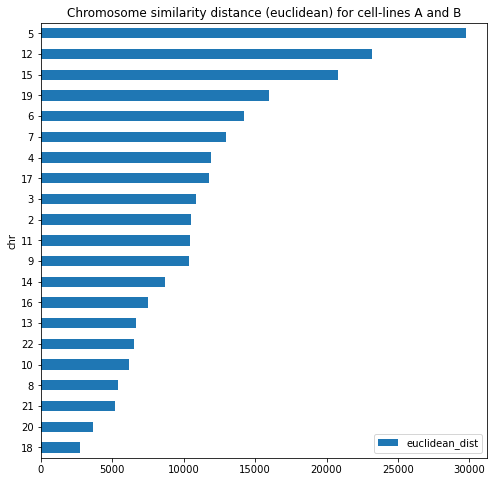

In [10]:
chr_sim = plot_chr_similartiy()

## Generating differential splits

Below I have constructed some data stratifiers based on Liines code. This will help us asess differential splits on the fly when we have a model

In [11]:
# Should contain mutually overlapping chromosomes and cell-lines
train, test = random_splits()

# chr overlap
print(set(train.chr))
print(set(test.chr))

# Cell-line overlap
print(set(train.cell_line))
print(set(test.cell_line))



{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
{1, 2}
{1, 2}


In [12]:
# Should contain mutually overlapping chromosomes but non-overlapping cell-lines
train, test = cell_line_splits()

# chr overlap
print(set(train.chr))
print(set(test.chr))

# Cell-line overlap
print(set(train.cell_line))
print(set(test.cell_line))


{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
{1}
{2}


In [13]:
# Should contain single cell-line between train and test ... unless cell_line is set to None, in which case: cell-lines overlap but not chromosomes
train, test = chromosome_splits(cell_line=1)
# chr overlap
print(set(train.chr))
print(set(test.chr))

# Cell-line overlap
print(set(train.cell_line))
print(set(test.cell_line))
print()

#################
train, test = chromosome_splits(cell_line=2)
# chr overlap
print(set(train.chr))
print(set(test.chr))

# Cell-line overlap
print(set(train.cell_line))
print(set(test.cell_line))
print()


#################

# set to None, cell-lines should overlap but be non-overlapping between chromosomes
train, test = chromosome_splits(cell_line=None) 

# chr overlap
print(set(train.chr))
print(set(test.chr))

# Cell-line overlap
print(set(train.cell_line))
print(set(test.cell_line))


{4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22}
{2, 3, 7, 10, 13, 17, 19}
{1}
{1}

{4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22}
{2, 3, 7, 10, 13, 17, 19}
{2}
{2}

{4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22}
{2, 3, 7, 10, 13, 17, 19}
{1, 2}
{1, 2}
